In [1]:


"""
pidp - individual identifier
wave - interview wave
urban_dv -urban or rural area
gor_dv - gov office region
age_dv - age in yrs
sex_dv - sex
hiqual_dv - highest educational quaification
ethn_dv - ethnicity
scghq1_dv - SWB GHQ Likert
sclfsato - Satisfaction with life overall
fimngrs_dv - Gross monthly personal income
mstat_dv - De facto marital status
jbstat - Current labour force status
sf12pcs_dv - SF-12 Physical Component Summary
"""

#Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import statsmodels.formula.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
import seaborn as sns
import patsy
from scipy import stats
from statsmodels.miscmodels.ordinal_model import OrderedModel

#Reading in the dataset
df = pd.read_spss("longitudinal_td.sav")

#Selecting variables of interest
variables = ["pidp","wave","urban_dv","gor_dv","age_dv","sex_dv","hiqual_dv","ethn_dv","scghq1_dv","sclfsato",
             "sf12pcs_dv","fimngrs_dv","mstat_dv","jbstat"]
df2 = df[variables]
df2 = df2.dropna(how="any") #dropping missing values
df2 = df2[(np.abs(stats.zscore(df2["fimngrs_dv"])) < 4)] #removing outliers of own income
df2 = df2[df2.fimngrs_dv > 1] #removing less than or equal to 1 income values
df2['log_fimngrs_dv'] = np.log(df2['fimngrs_dv']) #taking natural logs of the income

#Creating age categories 
conditions = [
    (df2['age_dv'] < 25),
    (df2['age_dv'] >= 25) & (df2['age_dv'] <= 34),
    (df2['age_dv'] >= 35) & (df2['age_dv'] <= 44),
    (df2['age_dv'] >= 45) & (df2['age_dv'] <= 65),
    (df2['age_dv'] > 65)]
values = ['<25 years old', '25-34 years old', '35-44 years old','45-65 years old', '65+ years old']
df2['Age category'] = np.select(conditions, values)

##Age squared and log of age 
df2['age_squared'] = np.square(df2['age_dv'])
df2['log_age'] = np.log(df2['age_dv'])

#Creating new numerical variable out of the categorical variable
df2['sclfsato_new'] = df2['sclfsato'].replace(to_replace=["completely dissatisfied", 'mostly dissatisfied', 
                                                     'somewhat dissatisfied', 'Neither Sat nor Dissat', 'somewhat satisfied',
                                                     'mostly satisfied','completely satisfied'], value=[1,2,3,4,5,6,7])


#Creating reference income
avrefin = df2.groupby(["gor_dv", "Age category", "sex_dv"])["fimngrs_dv"].transform("mean")
df2["avrefin"] = avrefin
df2['log_avrefin'] = np.log(df2['avrefin'])

#REGRESSION (using robust standard errors )




In [ ]:
#OLS regressions with and without time fixed effects
reg1 = sm.ols("sclfsato_new ~ log_avrefin +age_dv+age_squared+sf12pcs_dv  + sex_dv + ethn_dv + mstat_dv + hiqual_dv + jbstat +urban_dv", data = df2).fit(cov_type = 'cluster', cov_kwds={'groups': df2['pidp']})
reg2 = sm.ols("scghq1_dv ~ log_avrefin+age_dv + age_squared +sf12pcs_dv  + sex_dv + ethn_dv + mstat_dv + hiqual_dv + jbstat+urban_dv", data = df2).fit(cov_type = 'cluster', cov_kwds={'groups': df2['pidp']})
reg3 = sm.ols("sclfsato_new ~ log_avrefin+age_dv + age_squared +sf12pcs_dv + sex_dv + ethn_dv + mstat_dv + hiqual_dv + jbstat+urban_dv + C(wave)", data = df2).fit(cov_type = 'cluster', cov_kwds={'groups': df2['pidp']})
reg4 = sm.ols("scghq1_dv ~ log_avrefin+age_dv + age_squared +sf12pcs_dv + sex_dv + ethn_dv + mstat_dv + hiqual_dv +jbstat+urban_dv + C(wave)", data = df2).fit(cov_type = 'cluster', cov_kwds={'groups': df2['pidp']})

stargazer = Stargazer([reg1, reg2, reg3, reg4])
HTML(stargazer.render_html())

#OLS regressions for upwards and downwards groups
df_up = df2[(df2["avrefin"]>df2["fimngrs_dv"])]
df_down = df2[(df2["avrefin"]<df2["fimngrs_dv"])]

reg5 = sm.ols("sclfsato_new ~ log_avrefin +age_dv+age_squared+sf12pcs_dv  + sex_dv + ethn_dv + mstat_dv + hiqual_dv + jbstat +urban_dv+ C(wave)", data = df_up).fit(cov_type = 'cluster', cov_kwds={'groups': df_up['pidp']})
reg6 = sm.ols("scghq1_dv ~ log_avrefin+age_dv + age_squared +sf12pcs_dv  + sex_dv + ethn_dv + mstat_dv + hiqual_dv + jbstat+urban_dv+ C(wave)", data = df_up).fit(cov_type = 'cluster', cov_kwds={'groups': df_up['pidp']})
reg7 = sm.ols("sclfsato_new ~ log_avrefin+age_dv + age_squared +sf12pcs_dv + sex_dv + ethn_dv + mstat_dv + hiqual_dv + jbstat+urban_dv + C(wave)", data = df_down).fit(cov_type = 'cluster', cov_kwds={'groups': df_down['pidp']})
reg8 = sm.ols("scghq1_dv ~ log_avrefin+age_dv + age_squared +sf12pcs_dv + sex_dv + ethn_dv + mstat_dv + hiqual_dv +jbstat+urban_dv + C(wave)", data = df_down).fit(cov_type = 'cluster', cov_kwds={'groups': df_down['pidp']})

stargazer = Stargazer([reg5, reg6, reg7, reg8])
HTML(stargazer.render_html())


In [7]:
#READING IN DATA
#df = pd.read_spss("longitudinal_td.sav")

#ASSIGNING VARIABLES
#variables = ["pidp","wave","urban_dv","gor_dv","age_dv","sex_dv",
#             "hiqual_dv","ethn_dv","scghq1_dv","sclfsato","sf12pcs_dv","fimngrs_dv",
#             "hhsize_dv","mstat_dv","nchild_dv","sf1_dv","fihhmngrs_dv", "jbstat"]
#df2 = df[variables]
#df2 = df2.dropna(how="any")
df2 = df2[["age_dv", "scghq1_dv", "sf12pcs_dv", "fimngrs_dv"]]
dsc = df2.describe()
dsc.to_latex("my_df.tex")


In [100]:
cat_pred = ["sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
predictors = ["sclfsato_new","log_avrefin" ,"age_dv","age_squared","sf12pcs_dv","sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
df2 = pd.get_dummies(df2, columns=cat_pred, drop_first=True)

simple6 = sm.ols("sclfsato_new ~ log_avrefin + age_dv + age_squared + sf12pcs_dv + sex_dv_Male + ethn_dv_any other asian background+ ethn_dv_any other black background+ ethn_dv_any other ethnic group + ethn_dv_any other mixed background  + ethn_dv_arab + ethn_dv_bangladeshi+ ethn_dv_caribbean+ ethn_dv_chinese+ ethn_dv_gypsy or irish traveller+ ethn_dv_indian+ ethn_dv_irish+ ethn_dv_pakistani+ ethn_dv_white and asian+ ethn_dv_white and black african+ ethn_dv_white and black caribbean+ ethn_dv_white uk+ mstat_dv_married or civil partnership+ mstat_dv_separated or divorced+ mstat_dv_single+ mstat_dv_widowed+ hiqual_dv_Degree+ hiqual_dv_GCSE etc+ hiqual_dv_No qual+ hiqual_dv_Other higher+ hiqual_dv_Other qual+ jbstat_Govt training scheme+ jbstat_LT sick or disabled+ jbstat_On apprenticeship+ jbstat_Paid employment(ft/pt)+ jbstat_Unpaid, family business+ jbstat_doing something else+ jbstat_full-time student+ jbstat_on maternity leave+ jbstat_retired+ jbstat_self employed+ jbstat_unemployed+ urban_dv_urban area+ wave_2.0+ wave_3.0+ wave_4.0+ wave_5.0+ wave_6.0+ wave_7.0+ wave_8.0+ wave_9.0" ,data = df2).fit(cov_type = 'cluster', cov_kwds={'groups': df2['pidp']})

SyntaxError: invalid syntax (<unknown>, line 1)

In [87]:

v  = ["log_avrefin+ age_dv+ age_squared + sf12pcs_dv+ sex_dv_Male+ ethn_dv_any other asian background+ ethn_dv_any other black background+ ethn_dv_any other ethnic group+ ethn_dv_any other mixed background+ ethn_dv_any other white background+ ethn_dv_arab+ ethn_dv_bangladeshi+ ethn_dv_caribbean+ ethn_dv_chinese+ ethn_dv_gypsy or irish traveller+ ethn_dv_indian+ ethn_dv_irish+ ethn_dv_pakistani+ ethn_dv_white and asian+ ethn_dv_white and black african+ ethn_dv_white and black caribbean+ ethn_dv_white uk+ mstat_dv_married or civil partnership+ mstat_dv_separated or divorced+ mstat_dv_single+ mstat_dv_widowed+ hiqual_dv_Degree+ hiqual_dv_GCSE etc+ hiqual_dv_No qual+ hiqual_dv_Other higher+ hiqual_dv_Other qual+ jbstat_Govt training scheme+ jbstat_LT sick or disabled+ jbstat_On apprenticeship+ jbstat_Paid employment(ft/pt)+ jbstat_Unpaid, family business+ jbstat_doing something else+ jbstat_full-time student+ jbstat_on maternity leave+ jbstat_retired+ jbstat_self employed+ jbstat_unemployed+ urban_dv_urban area+ wave_2.0+ wave_3.0+ wave_4.0+ wave_5.0+ wave_6.0+ wave_7.0+ wave_8.0+ wave_9.0"]


In [2]:
covariate_names = {'C(wave)[T.2.0]': '2nd Wave', "C(wave)[T.3.0]":"3rd Wave", "C(wave)[T.4.0]":"4th Wave", "C(wave)[T.5.0]": "5th Wave",
                  "C(wave)[T.6.0]":"6th Wave", "C(wave)[T.7.0]":"7th Wave", "C(wave)[T.8.0]":"8th Wave", "C(wave)[T.9.0]":"9th Wave", 
                  "age_dv":"Age", "age_squared":"Age Squared", "ethn_dv[T.any other asian background]":"Other asian", "ethn_dv[T.any other black background]":"Other black",
                  "ethn_dv[T.any other ethnic group]": "Other ethnicity","ethn_dv[T.any other mixed background]":"Other mixed background", 
                  "ethn_dv[T.any other white background]":"Other white", "ethn_dv[T.arab]":"Arab", "ethn_dv[T.bangladeshi]":"Bangladeshi",
                  "ethn_dv[T.caribbean]":"Caribbean", "ethn_dv[T.chinese]": "Chinese", "ethn_dv[T.gypsy or irish traveller]":"Gypsy or Irish traveller",
                  "ethn_dv[T.indian]":"Indian", "ethn_dv[T.irish]":"Irish", "ethn_dv[T.pakistani]":"Pakistani", "ethn_dv[T.white and asian]":"white and asian", 
                  "ethn_dv[T.white and black african]":"white and black african", "ethn_dv[T.white and black caribbean]":"white and black caribbean",
                  "ethn_dv[T.white uk]":"white UK", "hiqual_dv[T.Degree]":"Degree", "hiqual_dv[T.GCSE etc]":"GCSE", "hiqual_dv[T.No qual]":"No qualification",
                  "hiqual_dv[T.Other higher]":"Other higher", "hiqual_dv[T.Other qual]":"Other qualification","jbstat[T.Govt training scheme]":"Government training scheme",
                  "jbstat[T.LT sick or disabled]":"Sick or disabled", "jbstat[T.On apprenticeship]":"Apprenticeship", "jbstat[T.Paid employment(ft/pt)]":"Paid employment",
                  "jbstat[T.Unpaid, family business]":"Unpaid or family business", "jbstat[T.doing something else]":"Doing something else",
                  "jbstat[T.full-time student]":"Full-time student", "jbstat[T.on maternity leave]":"On maternity leave","jbstat[T.retired]":"Retired",
                  "jbstat[T.self employed]":"Self employed", "jbstat[T.unemployed]":"Unemployed", "log_avrefin":"Log(RI)", "mstat_dv[T.married or civil partnership]":"Married",
                  "mstat_dv[T.separated or divorced]":"Divorced/Seperated", "mstat_dv[T.single]":"Single", "mstat_dv[T.widowed]":"Widowed",
                  "sex_dv[T.Male]":"Male", "sf12pcs_dv":"Physical health", "urban_dv[T.urban area]":"Urban area"}

In [4]:
covariates_ordered = ["Intercept",'log_avrefin','C(wave)[T.2.0]', 'C(wave)[T.3.0]', 'C(wave)[T.4.0]', 'C(wave)[T.5.0]', 'C(wave)[T.6.0]', 'C(wave)[T.7.0]', 'C(wave)[T.8.0]', 'C(wave)[T.9.0]', 'age_dv', 'age_squared', 'ethn_dv[T.any other asian background]', 'ethn_dv[T.any other black background]', 'ethn_dv[T.any other ethnic group]', 'ethn_dv[T.any other mixed background]', 'ethn_dv[T.any other white background]', 'ethn_dv[T.arab]', 'ethn_dv[T.bangladeshi]', 'ethn_dv[T.caribbean]', 'ethn_dv[T.chinese]', 'ethn_dv[T.gypsy or irish traveller]', 'ethn_dv[T.indian]', 'ethn_dv[T.irish]', 'ethn_dv[T.pakistani]', 'ethn_dv[T.white and asian]', 'ethn_dv[T.white and black african]', 'ethn_dv[T.white and black caribbean]', 'ethn_dv[T.white uk]', 'hiqual_dv[T.Degree]', 'hiqual_dv[T.GCSE etc]', 'hiqual_dv[T.No qual]', 'hiqual_dv[T.Other higher]', 'hiqual_dv[T.Other qual]', 'jbstat[T.Govt training scheme]', 'jbstat[T.LT sick or disabled]', 'jbstat[T.On apprenticeship]', 'jbstat[T.Paid employment(ft/pt)]', 'jbstat[T.Unpaid, family business]', 'jbstat[T.doing something else]', 'jbstat[T.full-time student]', 'jbstat[T.on maternity leave]', 'jbstat[T.retired]', 'jbstat[T.self employed]', 'jbstat[T.unemployed]', 'mstat_dv[T.married or civil partnership]', 'mstat_dv[T.separated or divorced]', 'mstat_dv[T.single]', 'mstat_dv[T.widowed]', 'sex_dv[T.Male]', 'sf12pcs_dv', 'urban_dv[T.urban area]']
covariates_subset = ["Intercept",'log_avrefin','C(wave)[T.2.0]', 'C(wave)[T.3.0]', 'C(wave)[T.4.0]', 'C(wave)[T.5.0]', 'C(wave)[T.6.0]', 'C(wave)[T.7.0]', 'C(wave)[T.8.0]', 'C(wave)[T.9.0]', 'age_dv', 'age_squared', "ethn_dv[T.chinese]",'ethn_dv[T.any other asian background]', 'ethn_dv[T.any other black background]', 'ethn_dv[T.any other white background]', 'ethn_dv[T.white uk]', 'hiqual_dv[T.Degree]', 'hiqual_dv[T.GCSE etc]', 'hiqual_dv[T.No qual]', 'jbstat[T.Paid employment(ft/pt)]', 'jbstat[T.full-time student]','jbstat[T.retired]', 'jbstat[T.unemployed]', 'jbstat[T.LT sick or disabled]','mstat_dv[T.married or civil partnership]', 'mstat_dv[T.separated or divorced]',  'mstat_dv[T.widowed]', 'sex_dv[T.Male]', 'sf12pcs_dv', 'urban_dv[T.urban area]']

In [84]:
df2["ethn_dv"].value_counts()

white uk                      137478
indian                          4307
any other white background      3948
caribbean                       2871
pakistani                       2590
african                         2333
irish                           2239
any other asian background      1562
bangladeshi                     1394
white and black caribbean        910
chinese                          715
any other mixed background       660
any other ethnic group           522
white and asian                  459
arab                             357
white and black african          319
any other black background       259
gypsy or irish traveller          19
Name: ethn_dv, dtype: int64

In [6]:
stargazer.custom_columns(['LS-RI()', 'SWB-RI', "LS-RI(FE)", "SWB-RI(FE)"], [1, 1, 1, 1])
stargazer.show_model_numbers(True)
stargazer.rename_covariates(covariate_names)
stargazer.covariate_order(covariates_subset)
HTML(stargazer.render_html())
#latex = stargazer.render_latex()
#print(simple6.summary())
#HTML(stargazer.render_html())
#open('regression.tex', 'w').write(stargazer.render_latex())  # for latex
#open('regression.html', 'w').write(stargazer.render_html())  # for html

                            OLS Regression Results                            
Dep. Variable:           sclfsato_new   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     147.4
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:10:20   Log-Likelihood:            -2.8363e+05
No. Observations:              162942   AIC:                         5.674e+05
Df Residuals:                  162890   BIC:                         5.679e+05
Df Model:                          51                                         
Covariance Type:              cluster                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [9]:
df2.groupby(["gor_dv", "wave"])["pidp"].count().mean()

1508.7222222222222

In [49]:
df2.shape[0]

162942

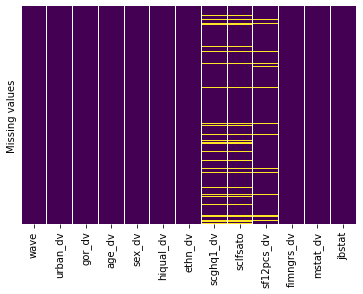

In [10]:
#Main analysis
#IMPOPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
import statsmodels.formula.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
import seaborn as sns
import patsy
from scipy import stats
from statsmodels.miscmodels.ordinal_model import OrderedModel

#READING IN DATA
df = pd.read_spss("longitudinal_td.sav")

#ASSIGNING VARIABLES
variables = ["wave","urban_dv","gor_dv","age_dv","sex_dv",
             "hiqual_dv","ethn_dv","scghq1_dv","sclfsato","sf12pcs_dv","fimngrs_dv",
             "mstat_dv", "jbstat"]
df2 = df[variables]
sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap="viridis",cbar_kws={'label': 'Missing Data'})
plt.ylabel("Missing values")
plt.savefig("heatmap_variables.png", dpi=1000, bbox_inches="tight")
# df2 = df2.dropna(how="any")
# df2.shape[0]

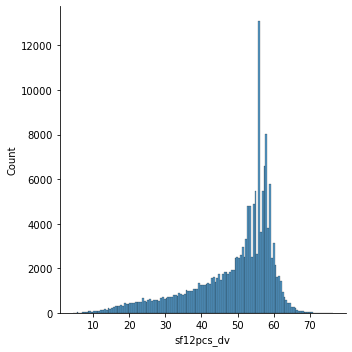

In [42]:
sns.displot(x=df2["sf12pcs_dv"], data=df2)

In [51]:
##OTHER OP MODEL
df2['scghq1_dv'] = pd.Categorical(df2.scghq1_dv, ordered=True)
cat_pred = ["sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
predictors = ["scghq1_dv","log_avrefin" ,"age_dv","age_squared","sf12pcs_dv","sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
df_op = df2[predictors]
df_op = pd.get_dummies(df_op, columns=cat_pred, drop_first=True)

# df_op.sclfsato = pd.Categorical(df_op.sclfsato, categories=['completely dissatisfied','mostly dissatisfied',
#                                                        'somewhat dissatisfied','Neither Sat nor Dissat', 
#                                                        'somewhat satisfied', 'mostly satisfied', 'completely satisfied'],ordered=True)
mod_prob = OrderedModel(df_op['scghq1_dv'],
                         df_op.loc[:, df_op.columns != "scghq1_dv"],
                         distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()
stargazer = Stargazer([res_prob])
HTML(stargazer.render_html())

Optimization terminated successfully.
         Current function value: 2.818199
         Iterations: 259
         Function evaluations: 265
         Gradient evaluations: 265


In [8]:
df["age_dv"].min()

16.0

<AxesSubplot:>

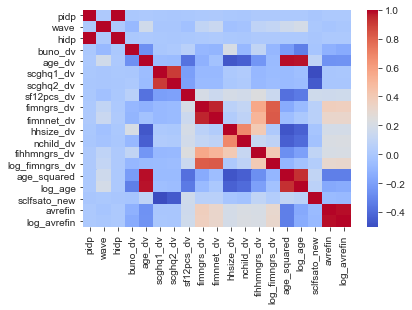

In [50]:
corrMatrix = df2.corr()
sns.heatmap(corrMatrix, annot = False, cmap= 'coolwarm')

([<matplotlib.axis.XTick at 0x3985ce1040>,
 [Text(0, 0, '16.0'),
  Text(1, 0, '17.0'),
  Text(2, 0, '18.0'),
  Text(3, 0, '19.0'),
  Text(4, 0, '20.0'),
  Text(5, 0, '21.0'),
  Text(6, 0, '22.0'),
  Text(7, 0, '23.0'),
  Text(8, 0, '24.0'),
  Text(9, 0, '25.0'),
  Text(10, 0, '26.0'),
  Text(11, 0, '27.0'),
  Text(12, 0, '28.0'),
  Text(13, 0, '29.0'),
  Text(14, 0, '30.0'),
  Text(15, 0, '31.0'),
  Text(16, 0, '32.0'),
  Text(17, 0, '33.0'),
  Text(18, 0, '34.0'),
  Text(19, 0, '35.0'),
  Text(20, 0, '36.0'),
  Text(21, 0, '37.0'),
  Text(22, 0, '38.0'),
  Text(23, 0, '39.0'),
  Text(24, 0, '40.0'),
  Text(25, 0, '41.0'),
  Text(26, 0, '42.0'),
  Text(27, 0, '43.0'),
  Text(28, 0, '44.0')])

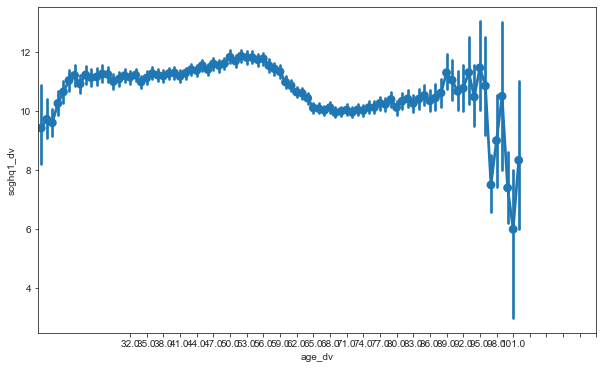

In [48]:
plt.figure(figsize=(10,6))
#sns.boxplot(x="sclfsato_new", y="age_dv", data=df2, showfliers=True, showmeans=False, flierprops = dict(markerfacecolor = '0.50', markersize = 1))
sns.pointplot(y="scghq1_dv", x="age_dv", data=df2)
plt.xticks(np.arange(min(df2["age_dv"]), max(df2["age_dv"])+1, 3))
#plt.savefig('globalTrafficDuringRoni.png', dpi = 1000)

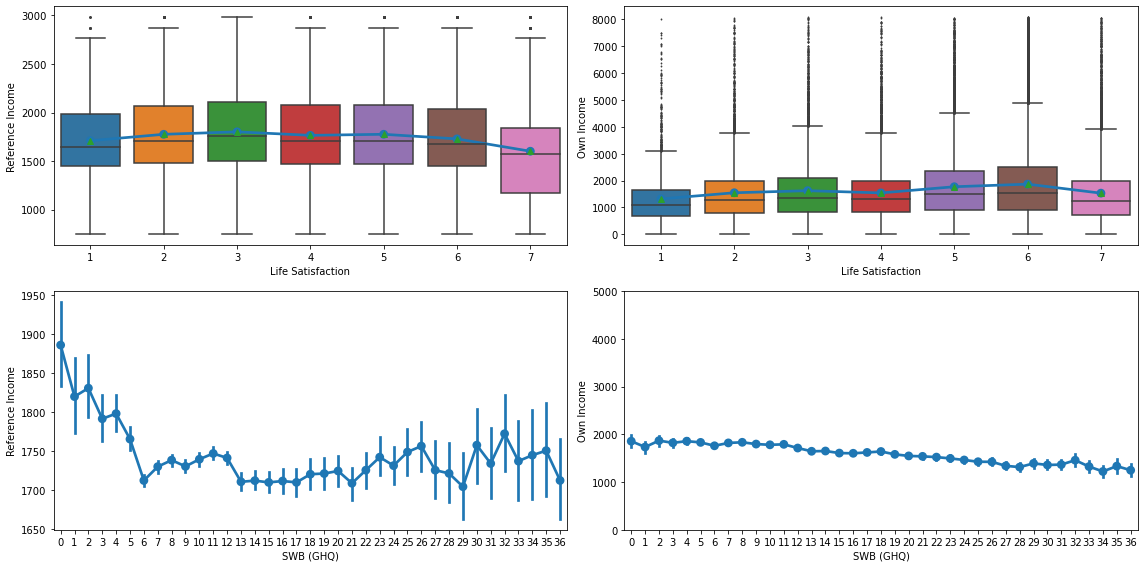

In [38]:

plt.rcParams["figure.autolayout"] = True
fig, axes =plt.subplots(2,2, figsize=(16,8))


sns.boxplot(x="sclfsato_new", y="avrefin", data=df2, showfliers=True, showmeans=True, flierprops = dict(markerfacecolor = '0.50', markersize = 1), ax=axes[0,0])
sns.pointplot(x="sclfsato_new", y="avrefin", data=df2, ax=axes[0,0])
plt.ylim(0,5000)
axes[0,0].set_xlabel('Life Satisfaction')
axes[0,0].set_ylabel("Reference Income")


sns.boxplot(x="sclfsato_new", y="fimngrs_dv", data=df2, showfliers=True, showmeans=True, flierprops = dict(markerfacecolor = '0.50', markersize = 1), ax=axes[0,1])
sns.pointplot(x="sclfsato_new", y="fimngrs_dv", data=df2, ax=axes[0,1])
plt.ylim(0,5000)
axes[0,1].set_xlabel('Life Satisfaction')
axes[0,1].set_ylabel("Own Income")

df2["scghq1_dv"] = df2["scghq1_dv"].astype("int")
sns.pointplot(x="scghq1_dv", y="avrefin", data=df2, ax=axes[1,0])
axes[1,0].set_xlabel('SWB (GHQ)')
axes[1,0].set_ylabel("Reference Income")

sns.pointplot(x="scghq1_dv", y="fimngrs_dv", data=df2, ax=axes[1,1])

axes[1,1].set_ylabel('Own Income')
axes[1,1].set_xlabel("SWB (GHQ)")


plt.savefig("income-SWB_boxplot.png", dpi=1000)

<AxesSubplot:xlabel='sclfsato_new', ylabel='avrefin'>

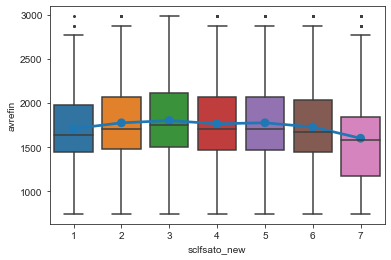

In [22]:
sns.boxplot(x="sclfsato_new", y="avrefin", data=df2, showfliers=True, showmeans=False, flierprops = dict(markerfacecolor = '0.50', markersize = 1))
sns.pointplot(x="sclfsato_new", y="avrefin", data=df2)


<Figure size 720x432 with 0 Axes>

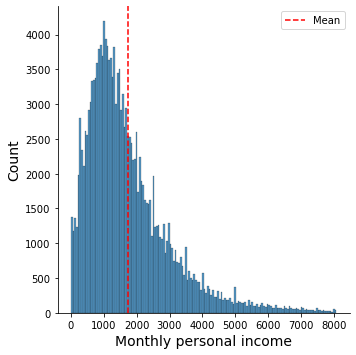

In [56]:

plt.figure(figsize=(10,6))
sns.displot(df2["fimngrs_dv"])
plt.xlabel("Monthly personal income", size=14)
plt.ylabel("Count", size=14)

plt.axvline(x=df2.fimngrs_dv.mean(), color='red', ls = "--", label="Mean")
plt.legend()
plt.savefig("income displot.png")

In [9]:
import re
import dataframe_image as dfi
df = pd.read_spss("longitudinal_td.sav")

#ASSIGNING VARIABLES
variables = ["age_dv","scghq1_dv","sclfsato","sf12pcs_dv","fimngrs_dv"]
df2 = df[variables]
df2 = df2.dropna(how="any")
df2['sclfsato_new'] = df2['sclfsato'].replace(to_replace=["completely dissatisfied", 'mostly dissatisfied', 
                                                     'somewhat dissatisfied', 'Neither Sat nor Dissat', 'somewhat satisfied',
                                                     'mostly satisfied','completely satisfied'], value=[1,2,3,4,5,6,7])

perc =[.20, .40, .60, .80, .95]
include =['object', 'float', 'int']
desc = df2.describe(percentiles = perc, include = include)
print(desc.to_latex("desc.tex"))

None


In [26]:
#UPWARDSNESS

df_up = df2[(df2["avrefin"]>df2["fimngrs_dv"])]
df_down = df2[(df2["avrefin"]<df2["fimngrs_dv"])]
#sns.scatterplot(x=df_up["fimngrs_dv"], y=df_up["avrefin"] , data=df_up)

#simple3 = sm.ols("sclfsato_new ~ log_avrefin ",data = df_up).fit(cov_type = 'cluster', cov_kwds={'groups': df_up['pidp']})
simple4 = sm.ols("sclfsato_new ~ log_avrefin +age_dv+age_squared+sf12pcs_dv  + sex_dv + ethn_dv + mstat_dv + hiqual_dv + jbstat +urban_dv+ C(wave)", data = df_up).fit(cov_type = 'cluster', cov_kwds={'groups': df_up['pidp']})
simple5 = sm.ols("scghq1_dv ~ log_avrefin+age_dv + age_squared +sf12pcs_dv  + sex_dv + ethn_dv + mstat_dv + hiqual_dv + jbstat+urban_dv+ C(wave)", data = df_up).fit(cov_type = 'cluster', cov_kwds={'groups': df_up['pidp']})
simple6 = sm.ols("sclfsato_new ~ log_avrefin+age_dv + age_squared +sf12pcs_dv + sex_dv + ethn_dv + mstat_dv + hiqual_dv + jbstat+urban_dv + C(wave)", data = df_down).fit(cov_type = 'cluster', cov_kwds={'groups': df_down['pidp']})
simple7 = sm.ols("scghq1_dv ~ log_avrefin+age_dv + age_squared +sf12pcs_dv + sex_dv + ethn_dv + mstat_dv + hiqual_dv +jbstat+urban_dv + C(wave)", data = df_down).fit(cov_type = 'cluster', cov_kwds={'groups': df_down['pidp']})
#print(simple4.summary())
stargazer = Stargazer([simple4, simple5, simple6, simple7])
#stargazer.show_header(True)
stargazer.custom_columns(['LS-RI (Upwards)', 'SWB-RI (Upwards)', "LS-RI (Downwards)", "SWB-RI (Downwards)"], [1,1,1,1])
stargazer.show_model_numbers(True)
stargazer.rename_covariates(covariate_names)
stargazer.covariate_order(covariates_subset)
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
\\[-1.8ex] & \multicolumn{1}{c}{LS-RI (Upwards)} & \multicolumn{1}{c}{SWB-RI (Upwards)} & \multicolumn{1}{c}{LS-RI (Downwards)} & \multicolumn{1}{c}{SWB-RI (Downwards)}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 Intercept & 5.630$^{***}$ & 10.554$^{***}$ & 4.905$^{***}$ & 8.705$^{***}$ \\
  & (0.294) & (1.154) & (0.297) & (1.139) \\
 Log(RI) & -0.188$^{***}$ & 0.634$^{***}$ & -0.057$^{}$ & 0.678$^{***}$ \\
  & (0.041) & (0.160) & (0.043) & (0.164) \\
 2nd Wave & -0.057$^{***}$ & 0.075$^{}$ & -0.056$^{***}$ & 0.153$^{**}$ \\
  & (0.014) & (0.049) & (0.017) & (0.063) \\
 3rd Wave & -0.152$^{***}$ & -0.005$^{}$ & -0.115$^{***}$ & 0.026$^{}$ \\
  & (0.015) & (0.053) & (0.019) & (0.066) \\
 4th Wave & -0.248$^{***}$ & -0.048$^{}$ & -0.204$^{***}$ & 0.013$^{}$ \\
  & (0.016) & (0.056) & (0.019) & (0.068) \\
 5th Wave & -0.265$^{***}$ & 0.194$^{***}$ & -0.225$^{***}$

In [122]:
df["sex_dv"].value_counts()

Female    110979
Male       81167
Name: sex_dv, dtype: int64

In [10]:
df_down.shape[0]

66502

In [32]:
# ## OP MODEL UP/DOWN
# cat_pred = ["sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
# predictors_ls = ["sclfsato","log_avrefin" ,"age_dv","age_squared","sf12pcs_dv","sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
# predictors_swb = ["scghq1_dv","log_avrefin" ,"age_dv","age_squared","sf12pcs_dv","sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]

# df_op_up = df_up[predictors_ls]
# df_op_down = df_down[predictors_ls]

# df_op_up = pd.get_dummies(df_op_up, columns=cat_pred, drop_first=True)
# df_op_down = pd.get_dummies(df_op_down, columns=cat_pred, drop_first=True)

# df_op_up.sclfsato = pd.Categorical(df_op_up.sclfsato, categories=['completely dissatisfied','mostly dissatisfied',
#                                                        'somewhat dissatisfied','Neither Sat nor Dissat', 
#                                                        'somewhat satisfied', 'mostly satisfied', 'completely satisfied'],ordered=True)
# df_op_down.sclfsato = pd.Categorical(df_op_down.sclfsato, categories=['completely dissatisfied','mostly dissatisfied',
#                                                        'somewhat dissatisfied','Neither Sat nor Dissat', 
#                                                        'somewhat satisfied', 'mostly satisfied', 'completely satisfied'],ordered=True)

# mod_prob_up_ls = OrderedModel(df_op_up['sclfsato'],
#                          df_op_up.loc[:, df_op_up.columns != "sclfsato"],
#                          distr='probit')

# predictors_swb = ["scghq1_dv","log_avrefin" ,"age_dv","age_squared","sf12pcs_dv","sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
# df_op_up = df_up[predictors_swb]
# df_op_up['scghq1_dv'] = pd.Categorical(df_op_up.scghq1_dv, ordered=True)

# mod_prob_up_swb = OrderedModel(df_op_up['scghq1_dv'],
#                          df_op_up.loc[:, df_op_up.columns != "scghq1_dv"],
#                          distr='probit')


# mod_prob_down_ls = OrderedModel(df_op_down['sclfsato'],
#                          df_op_down.loc[:, df_op_down.columns != "sclfsato"],
#                          distr='probit')

# predictors_swb = ["scghq1_dv","log_avrefin" ,"age_dv","age_squared","sf12pcs_dv","sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
# df_op_down = df_down[predictors_swb]
# df_op_down['scghq1_dv'] = pd.Categorical(df_op_down.scghq1_dv, ordered=True)

# mod_prob_down_swb = OrderedModel(df_op_down['scghq1_dv'],
#                          df_op_down.loc[:, df_op_down.columns != "scghq1_dv"],
#                          distr='probit')

# res_prob1 = mod_prob_up_ls.fit(method='bfgs')
# res_prob2 = mod_prob_up_swb.fit(method='bfgs')
# res_prob3 = mod_prob_down_ls.fit(method='bfgs')
# res_prob4 = mod_prob_down_swb.fit(method='bfgs')


# stargazer_op_updown = Stargazer([res_prob1,res_prob2, res_prob3, res_prob4 ])
# HTML(stargazer.render_html())


In [28]:
#ORDERED PROBIT MODEL (dont run takes half an hour)

cat_pred = ["sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
predictors_ls = ["sclfsato","log_avrefin" ,"age_dv","age_squared","sf12pcs_dv","sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
predictors_swb = ["scghq1_dv","log_avrefin" ,"age_dv","age_squared","sf12pcs_dv","sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
df2['scghq1_dv'] = pd.Categorical(df2.scghq1_dv, ordered=True)


df_op_ls = df2[predictors_ls]
df_op_swb = df2[predictors_swb]

df_op_ls = pd.get_dummies(df_op_ls, columns=cat_pred, drop_first=True)
df_op_swb = pd.get_dummies(df_op_swb, columns=cat_pred, drop_first=True)

df_op_ls.sclfsato = pd.Categorical(df_op_ls.sclfsato, categories=['completely dissatisfied','mostly dissatisfied',
                                                       'somewhat dissatisfied','Neither Sat nor Dissat', 
                                                       'somewhat satisfied', 'mostly satisfied', 'completely satisfied'],ordered=True)
mod_prob_ls = OrderedModel(df_op_ls['sclfsato'],
                         df_op_ls.loc[:, df_op_ls.columns != "sclfsato"],
                         distr='probit')

mod_prob_swb = OrderedModel(df_op_swb['scghq1_dv'],
                         df_op_swb.loc[:, df_op_swb.columns != "scghq1_dv"],
                         distr='probit')

res_prob1 = mod_prob_ls.fit(method='bfgs')
res_prob2 = mod_prob_swb.fit(method='bfgs')


stargazer_op = Stargazer([res_prob1, res_prob2])
HTML(stargazer_op.render_html())


Optimization terminated successfully.
         Current function value: 1.517314
         Iterations: 252
         Function evaluations: 258
         Gradient evaluations: 258
Optimization terminated successfully.
         Current function value: 2.818199
         Iterations: 259
         Function evaluations: 265
         Gradient evaluations: 265


In [102]:
covariate_names = {'wave_2.0': '2nd Wave', "wave_3.0":"3rd Wave", "wave_4.0":"4th Wave", "wave_5.0": "5th Wave",
                  "wave_6.0":"6th Wave", "wave_7.0":"7th Wave", "wave_8.0":"8th Wave", "wave_9.0":"9th Wave", 
                  "age_dv":"Age", "age_squared":"Age Squared", "ethn_dv_any other asian background":"Other asian", "ethn_dv_any other black background":"Other black",
                  "ethn_dv_any other ethnic group": "Other ethnicity","ethn_dv_any other mixed background":"Other mixed background", 
                  "ethn_dv_any other white background":"Other white", "ethn_dv_arab":"Arab", "ethn_dv_bangladeshi":"Bangladeshi",
                  "ethn_dv_caribbean":"Caribbean", "ethn_dv_chinese": "Chinese", "ethn_dv_gypsy or irish traveller":"Gypsy or Irish traveller",
                  "ethn_dv_indian":"Indian", "ethn_dv_irish":"Irish", "ethn_dv_pakistani":"Pakistani", "ethn_dv_white and asian":"white and asian", 
                  "ethn_dv_white and black african":"white and black african", "ethn_dv_white and black caribbean":"white and black caribbean",
                  "ethn_dv_white uk":"white UK", "hiqual_dv_Degree":"Degree", "hiqual_dv_GCSE etc":"GCSE", "hiqual_dv_No qual":"No qualification",
                  "hiqual_dv_Other higher":"Other higher", "hiqual_dv_Other qual":"Other qualification","jbstat_Govt training scheme":"Government training scheme",
                  "jbstat_LT sick or disabled":"Sick or disabled", "jbstat_On apprenticeship":"Apprenticeship", "jbstat_Paid employment(ft/pt)":"Paid employment",
                  "jbstat_Unpaid, family business":"Unpaid or family business", "jbstat_doing something else":"Doing something else",
                  "jbstat_full-time student":"Full-time student", "jbstat_on maternity leave":"On maternity leave","jbstat_retired":"Retired",
                  "jbstat_self employed":"Self employed", "jbstat_unemployed":"Unemployed", "log_avrefin":"Log(RI)", "mstat_dv_married or civil partnership":"Married",
                  "mstat_dv_separated or divorced":"Divorced/Seperated", "mstat_dv_single":"Single", "mstat_dv_widowed":"Widowed",
                  "sex_dv_Male":"Male", "sf12pcs_dv":"Physical health", "urban_dv_urban area":"Urban area"}

In [103]:
covariates_ordered= ['wave_2.0', 'wave_3.0', 'wave_4.0', 'wave_5.0', 'wave_6.0', 'wave_7.0', 'wave_8.0', 'wave_9.0', 'age_dv',
                     'age_squared', 'ethn_dv_any other asian background', 'ethn_dv_any other black background', 'ethn_dv_any other ethnic group',
                     'ethn_dv_any other mixed background', 'ethn_dv_any other white background', 'ethn_dv_arab', 'ethn_dv_bangladeshi', 'ethn_dv_caribbean',
                     'ethn_dv_chinese', 'ethn_dv_gypsy or irish traveller', 'ethn_dv_indian', 'ethn_dv_irish', 'ethn_dv_pakistani', 'ethn_dv_white and asian',
                     'ethn_dv_white and black african', 'ethn_dv_white and black caribbean', 'ethn_dv_white uk', 'hiqual_dv_Degree', 'hiqual_dv_GCSE etc',
                     'hiqual_dv_No qual', 'hiqual_dv_Other higher', 'hiqual_dv_Other qual', 'jbstat_Govt training scheme', 'jbstat_LT sick or disabled',
                     'jbstat_On apprenticeship', 'jbstat_Paid employment(ft/pt)', 'jbstat_Unpaid, family business', 'jbstat_doing something else',
                     'jbstat_full-time student', 'jbstat_on maternity leave', 'jbstat_retired', 'jbstat_self employed', 'jbstat_unemployed',
                     'log_avrefin', 'mstat_dv_married or civil partnership', 'mstat_dv_separated or divorced', 'mstat_dv_single', 'mstat_dv_widowed',
                     'sex_dv_Male', 'sf12pcs_dv', 'urban_dv_urban area']

In [104]:
covariates_subset= [ 'log_avrefin','wave_2.0', 'wave_3.0', 'wave_4.0', 'wave_5.0', 'wave_6.0', 'wave_7.0', 'wave_8.0', 'wave_9.0', 'age_dv',
                     'age_squared', 'ethn_dv_any other asian background', 'ethn_dv_any other black background', 'ethn_dv_any other ethnic group',
                      'ethn_dv_any other white background', 'ethn_dv_arab', 
                     'ethn_dv_chinese',   
                       'ethn_dv_white uk', 'hiqual_dv_Degree', 'hiqual_dv_GCSE etc',
                     'hiqual_dv_No qual', 'jbstat_LT sick or disabled',
                      'jbstat_Paid employment(ft/pt)',
                     'jbstat_full-time student', 'jbstat_retired',  'jbstat_unemployed',
                     'mstat_dv_married or civil partnership', 'mstat_dv_separated or divorced', 'mstat_dv_single', 'mstat_dv_widowed',
                     'sex_dv_Male', 'sf12pcs_dv', 'urban_dv_urban area']

In [111]:
#covariates_ordered = ['log_avrefin','C(wave)[T.2.0]', 'C(wave)[T.3.0]', 'C(wave)[T.4.0]', 'C(wave)[T.5.0]', 'C(wave)[T.6.0]', 'C(wave)[T.7.0]', 'C(wave)[T.8.0]', 'C(wave)[T.9.0]', 'age_dv', 'age_squared', 'ethn_dv[T.any other asian background]', 'ethn_dv[T.any other black background]', 'ethn_dv[T.any other ethnic group]', 'ethn_dv[T.any other mixed background]', 'ethn_dv[T.any other white background]', 'ethn_dv[T.arab]', 'ethn_dv[T.bangladeshi]', 'ethn_dv[T.caribbean]', 'ethn_dv[T.chinese]', 'ethn_dv[T.gypsy or irish traveller]', 'ethn_dv[T.indian]', 'ethn_dv[T.irish]', 'ethn_dv[T.pakistani]', 'ethn_dv[T.white and asian]', 'ethn_dv[T.white and black african]', 'ethn_dv[T.white and black caribbean]', 'ethn_dv[T.white uk]', 'hiqual_dv[T.Degree]', 'hiqual_dv[T.GCSE etc]', 'hiqual_dv[T.No qual]', 'hiqual_dv[T.Other higher]', 'hiqual_dv[T.Other qual]', 'jbstat[T.Govt training scheme]', 'jbstat[T.LT sick or disabled]', 'jbstat[T.On apprenticeship]', 'jbstat[T.Paid employment(ft/pt)]', 'jbstat[T.Unpaid, family business]', 'jbstat[T.doing something else]', 'jbstat[T.full-time student]', 'jbstat[T.on maternity leave]', 'jbstat[T.retired]', 'jbstat[T.self employed]', 'jbstat[T.unemployed]', 'mstat_dv[T.married or civil partnership]', 'mstat_dv[T.separated or divorced]', 'mstat_dv[T.single]', 'mstat_dv[T.widowed]', 'sex_dv[T.Male]', 'sf12pcs_dv', 'urban_dv[T.urban area]']
#covariates_subset = ['log_avrefin','C(wave)[T.2.0]', 'C(wave)[T.3.0]', 'C(wave)[T.4.0]', 'C(wave)[T.5.0]', 'C(wave)[T.6.0]', 'C(wave)[T.7.0]', 'C(wave)[T.8.0]', 'C(wave)[T.9.0]', 'age_dv', 'age_squared', "ethn_dv[T.chinese]",'ethn_dv[T.any other asian background]', 'ethn_dv[T.any other black background]', 'ethn_dv[T.any other white background]', 'ethn_dv[T.white uk]', 'hiqual_dv[T.Degree]', 'hiqual_dv[T.GCSE etc]', 'hiqual_dv[T.No qual]', 'jbstat[T.Paid employment(ft/pt)]', 'jbstat[T.full-time student]','jbstat[T.retired]', 'jbstat[T.unemployed]', 'jbstat[T.LT sick or disabled]','mstat_dv[T.married or civil partnership]', 'mstat_dv[T.separated or divorced]',  'mstat_dv[T.widowed]', 'sex_dv[T.Male]', 'sf12pcs_dv', 'urban_dv[T.urban area]']
dict_keys = list(covariate_names.keys())
covariates_subset = ["completely dissatisfied/mostly dissatisfied","mostly dissatisfied/somewhat dissatisfied","somewhat dissatisfied/Neither Sat nor Dissat","Neither Sat nor Dissat/somewhat satisfied",  "somewhat satisfied/mostly satisfied","mostly satisfied/completely satisfied"]+["log_avrefin"]

stargazer_op = Stargazer([res_prob1, simple6])
stargazer_op.custom_columns(["LS-RI(OP)", "LS-RI(OLS)"], [1,1])
stargazer_op.show_model_numbers(True)
stargazer_op.rename_covariates(covariate_names)
stargazer_op.covariate_order(covariates_subset)

#print(mod_prob_ls.get_margeff().summary()) 
#mod_prob_ls.get_margeff(at='overall', method='dydx', atexog=None, dummy=False, count=False)

AttributeError: 'OrderedModel' object has no attribute 'get_margeff'

In [51]:
list(covariate_names.keys())

['wave_2.0',
 'wave_3.0',
 'wave_4.0',
 'wave_5.0',
 'wave_6.0',
 'wave_7.0',
 'wave_8.0',
 'wave_9.0',
 'age_dv',
 'age_squared',
 'ethn_dv_any other asian background',
 'ethn_dv_any other black background',
 'ethn_dv_any other ethnic group',
 'ethn_dv_any other mixed background',
 'ethn_dv_any other white background',
 'ethn_dv_arab',
 'ethn_dv_bangladeshi',
 'ethn_dv_caribbean',
 'ethn_dv_chinese',
 'ethn_dv_gypsy or irish traveller',
 'ethn_dv_indian',
 'ethn_dv_irish',
 'ethn_dv_pakistani',
 'ethn_dv_white and asian',
 'ethn_dv_white and black african',
 'ethn_dv_white and black caribbean',
 'ethn_dv_white uk',
 'hiqual_dv_Degree',
 'hiqual_dv_GCSE etc',
 'hiqual_dv_No qual',
 'hiqual_dv_Other higher',
 'hiqual_dv_Other qual',
 'jbstat_Govt training scheme',
 'jbstat_LT sick or disabled',
 'jbstat_On apprenticeship',
 'jbstat_Paid employment(ft/pt)',
 'jbstat_Unpaid, family business',
 'jbstat_doing something else',
 'jbstat_full-time student',
 'jbstat_on maternity leave',
 'jbst

In [ ]:
## OP MODEL DOWNWARDNESS
cat_pred = ["sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
predictors = ["sclfsato","log_avrefin" ,"age_dv","age_squared","sf12pcs_dv","sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
df_op = df_down[predictors]
df_op = pd.get_dummies(df_op, columns=cat_pred, drop_first=True)

df_op.sclfsato = pd.Categorical(df_op.sclfsato, categories=['completely dissatisfied','mostly dissatisfied',
                                                       'somewhat dissatisfied','Neither Sat nor Dissat', 
                                                       'somewhat satisfied', 'mostly satisfied', 'completely satisfied'],ordered=True)
mod_prob = OrderedModel(df_op['sclfsato'],
                         df_op.loc[:, df_op.columns != "sclfsato"],
                         distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()
stargazer = Stargazer([res_prob])
HTML(stargazer.render_html())

In [24]:
file_name = "test.tex" #Include directory path if needed
tex_file = open( file_name, "w" ) #This will overwrite an existing file
tex_file.write(stargazer.render_latex())
tex_file.close()

<AxesSubplot:ylabel='fimngrs_dv'>

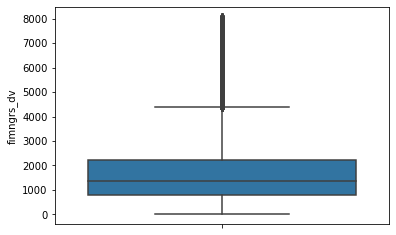

In [2]:
#ORDERED PROBIT MODEL

cat_pred = ["sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
predictors = ["sclfsato","log_avrefin" ,"age_dv","age_squared","sf12pcs_dv","sex_dv","ethn_dv","mstat_dv","hiqual_dv","jbstat","urban_dv","wave"]
df_op = df2[predictors]
df_op = pd.get_dummies(df_op, columns=cat_pred, drop_first=True)

df_op.sclfsato = pd.Categorical(df_op.sclfsato, categories=['completely dissatisfied','mostly dissatisfied',
                                                       'somewhat dissatisfied','Neither Sat nor Dissat', 
                                                       'somewhat satisfied', 'mostly satisfied', 'completely satisfied'],ordered=True)
mod_prob = OrderedModel(df_op['sclfsato'],
                         df_op.loc[:, df_op.columns != "sclfsato"],
                         distr='probit')

res_prob = mod_prob.fit(method='bfgs')
stargazer = Stargazer([res_prob])
HTML(stargazer.render_html())

Optimization terminated successfully.
         Current function value: 1.521074
         Iterations: 244
         Function evaluations: 250
         Gradient evaluations: 250


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:               sclfsato   Log-Likelihood:            -2.5485e+05
Model:                   OrderedModel   AIC:                         5.098e+05
Method:            Maximum Likelihood   BIC:                         5.104e+05
Date:                Thu, 24 Mar 2022                                         
Time:                        16:14:44                                         
No. Observations:              167543                                         
Df Residuals:                  167486                                         
Df Model:                          57                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
log_avrefin                                     -0.1582      0.015    -10.240      0.000      -0.188      -0.128
age_dv                                          -0.0161      0.001    -12.970      0.000      -0.019      -0.014
age_squared                                      0.0002   1.22e-05     16.917      0.000       0.000       0.000
sf12pcs_dv                                       0.0184      0.000     69.564      0.000       0.018       0.019
sex_dv_Male                                     -0.0086      0.008     -1.105      0.269      -0.024       0.007
ethn_dv_any other asian background               0.0455      0.033      1.385      0.166      -0.019       0.110
ethn_dv_any other black background               0.0302      0.068      0.445      0.656      -0.103       0.163
ethn_dv_any other ethnic group                  -0.0040      0.049     -0.082      0.935      -0.100       0.092
ethn_dv_any other mixed background              -0.0806      0.044     -1.811      0.070      -0.168       0.007
ethn_dv_any other white background               0.0360      0.027      1.349      0.177      -0.016       0.088
ethn_dv_arab                                    -0.1079      0.054     -2.005      0.045      -0.213      -0.002
ethn_dv_bangladeshi                             -0.0691      0.034     -2.024      0.043      -0.136      -0.002
ethn_dv_caribbean                               -0.0568      0.028     -1.994      0.046      -0.113      -0.001
ethn_dv_chinese                                 -0.0937      0.043     -2.177      0.029      -0.178      -0.009
ethn_dv_gypsy or irish traveller                 0.2430      0.242      1.005      0.315      -0.231       0.717
ethn_dv_indian                                   0.0440      0.026      1.687      0.092      -0.007       0.095
ethn_dv_irish                                    0.0854      0.031      2.791      0.005       0.025       0.145
ethn_dv_pakistani                               -0.0829      0.029     -2.871      0.004      -0.139      -0.026
ethn_dv_white and asian                          0.0568      0.052      1.101      0.271      -0.044       0.158
ethn_dv_white and black african                 -0.1219      0.061     -1.989      0.047      -0.242      -0.002
ethn_dv_white and black caribbean                0.0036      0.040      0.090      0.928      -0.075       0.082
ethn_dv_white uk                                 0.1140      0.021      5.328      0.000       0.072       0.156
mstat_dv_married or civil partnership            0.1171      0.009     12.780      0.000       0.099       0.135
mstat_dv_separated or divorced                  -0.2148      0.012    -18.232      0.000      -0.238      -0.192
mstat_dv_single                                 -0.1597      0.011    -14.839      0.000      -0.181      -0.13

In [31]:
df2.groupby(["gor_dv","hiqual_dv", "age_dv"])["fimngrs_dv"].mean()

gor_dv                    hiqual_dv    age_dv
east midlands             A level etc  25.0      1480.336116
                                       26.0      1424.539702
                                       27.0      1563.321471
                                       28.0      1581.101754
                                       29.0      1551.759552
                                                    ...     
yorkshire and the humber  Other qual   61.0      1085.261061
                                       62.0      1043.738665
                                       63.0      1138.361367
                                       64.0       958.039589
                                       65.0       984.378825
Name: fimngrs_dv, Length: 2952, dtype: float64

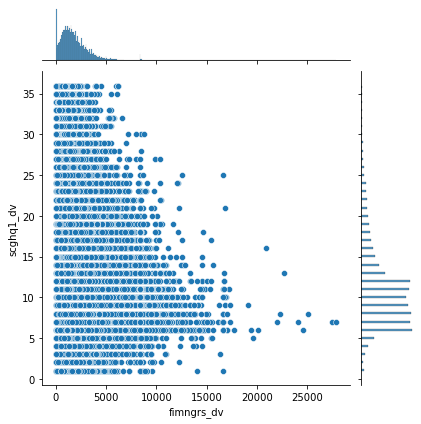

In [10]:
sns.jointplot(x="fimngrs_dv",y="scghq1_dv", data=df2)

In [12]:
"""
pidp - individual identifier
wave - interview wave
hidp - household identifier
buno_dv - benefit unit within household ??
urban_dv -urban or rural area
gor_dv - gov office region
age_dv - age in yrs
sex_dv - sex
hiqual_dv - highest educational quaification
ethn_dv - ethnicity
scghq1_dv - SWB GHQ Likert
scghq2_dv - SWB GHQ Caseness
sclfsato - Satisfaction with life overall
paygu_dv(removed) - Usual gross monthly pay of current job  (might be imputed)
paynu_dv(removed) - Usual net monthly pay of current job
fimngrs_dv - Gross monthly personal income
fimnnet_dv - Net monthly personal income, no deductions
hhsize_dv - Household size
mstat_dv - De facto marital status
nchild_dv - Number of own children in household
sf1_dv - General health
jbstat - Current labour force status
jbsat (removed) - Job satisfaction (1-7)
fihhmngrs_dv - Gross monthly household income (before housing costs)
sf12pcs_dv - SF-12 Physical Component Summary


"""

'\npidp - individual identifier\nwave - interview wave\nhidp - household identifier\nbuno_dv - benefit unit within household ??\nurban_dv -urban or rural area\ngor_dv - gov office region\nage_dv - age in yrs\nsex_dv - sex\nhiqual_dv - highest educational quaification\nethn_dv - ethnicity\nscghq1_dv - SWB GHQ Likert\nscghq2_dv - SWB GHQ Caseness\nsclfsato - Satisfaction with life overall\npaygu_dv(removed) - Usual gross monthly pay of current job  (might be imputed)\npaynu_dv(removed) - Usual net monthly pay of current job\nfimngrs_dv - Gross monthly personal income\nfimnnet_dv - Net monthly personal income, no deductions\nhhsize_dv - Household size\nmstat_dv - De facto marital status\nnchild_dv - Number of own children in household\nsf1_dv - General health\njbstat - Current labour force status\njbsat (removed) - Job satisfaction (1-7)\nfihhmngrs_dv - Gross monthly household income (before housing costs)\n\n\n'

In [ ]:
"""
pidp - individual identifier
wave - interview wave
urban_dv -urban or rural area
gor_dv - gov office region
age_dv - age in yrs
sex_dv - sex
hiqual_dv - highest educational quaification
ethn_dv - ethnicity
scghq1_dv - SWB GHQ Likert
sclfsato - Satisfaction with life overall
fimngrs_dv - Gross monthly personal income
mstat_dv - De facto marital status
jbstat - Current labour force status
sf12pcs_dv - SF-12 Physical Component Summary
"""
